In [79]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config

---
# Collecting data
Our data is about Rolex watches which are sold on `chrono24.com`.

Yes, He allows us to freely use the dataset.

He collected this data by scraping with Selenium

---
# Exploring data

In [80]:
rolex_df = pd.read_csv('rolex_scaper_clean.csv')

#### Number of rows and columns

In [81]:
num_rows,num_cols = rolex_df.shape
rolex_df.shape

(87117, 12)

#### Meaning of each row
We can see that each row has information like model, price, ... about the watch.

In [82]:
rolex_df.head()

,model,reference number,price,aditional shipping price,ad name,movement,case material,case diameter,year of production,condition,scope of delivery,location
0,Rolex Lady-Datejust,179161,9080.0,140.0,Steel Rose Gold Black Roman Dial Ladies Watch ...,Automatic,Steel,26 mm,2014.0,Very good,"Original box, original papers","United States of America, Georgia"
1,Rolex Chronograph,2917,16202.0,216.0,REF. 2917,Manual winding,Steel,33 mm,1934.0,Very good,"Original box, no original papers","Italy, Roma"
2,Rolex Daytona,116519G,41567.0,0.0,保証書付き ROLEX ロレックス デイトナ コスモグラフ K18WG 8Pダイヤ ランダム...,Automatic,White gold,39 mm,NaN,Fair,"Original papers, no original box","Japan, Nagoya City"
3,Rolex Submariner Date,116613,19795.0,235.0,New Submariner 116613 Yellow Steel Gold Cerami...,Automatic,Steel,40 mm,2020.0,Unworn,"Original box, original papers","United States of America, Florida, Miami"
4,Rolex Submariner Date,16610,10674.0,145.0,1990s ROLEX SUBMARINER 16610 Tritium vintage G...,Automatic,NaN,40 mm,1990.0,Good,"Original box, original papers","Japan, Ehime yawatahama"


#### Are there duplicated rows ?

In [83]:
rolex_df.duplicated(keep='first').sum()

21898

Drop duplicated rows

In [84]:
rolex_df.drop_duplicates(inplace=True)

#### Meaning of each columns ?

model: the watch model name

reference number: the number to identify the watch model as a whole

price: the price on the listing (price made by the reseller)

additional shipping price: the price for shipping (0 = free shipping)

ad name: the name of the listing on the site

movement: the engine of a watch to make the watch and its functions operate

case material: the material of the external watch case

case diameter: the dimensions of the watch

year of production: the year when Rolex fabricate that particular watch

condition: the general condition of the watch

scope of delivery: the additional things like warranty, or box that could come with the watch

location: the location of the reseller


#### Type of each colum 
Luckily, all columns are in their right data types except for year of production. It should be categorical (object) instead of float64.

In [85]:
rolex_df.dtypes 

model                        object
reference number             object
price                       float64
aditional shipping price    float64
ad name                      object
movement                     object
case material                object
case diameter                object
year of production          float64
condition                    object
scope of delivery            object
location                     object
dtype: object

Change data types of year of production column

In [86]:
rolex_df['year of production'] = rolex_df['year of production'].astype('object')
rolex_df.dtypes

model                        object
reference number             object
price                       float64
aditional shipping price    float64
ad name                      object
movement                     object
case material                object
case diameter                object
year of production           object
condition                    object
scope of delivery            object
location                     object
dtype: object

#### With each numerical column, how are values distributed?

In [87]:
numerical_cols = rolex_df.select_dtypes(include=np.number).copy()
numerical_cols.head()

,price,aditional shipping price
0,9080.0,140.0
1,16202.0,216.0
2,41567.0,0.0
3,19795.0,235.0
4,10674.0,145.0


Proportion of missing values

In [88]:
num_missing_percentages = (numerical_cols.isna()).sum() / rolex_df.shape[0] * 100
num_missing_percentages

price                       6.271179
aditional shipping price    0.000000
dtype: float64

Describe

In [89]:
numerical_cols.describe()

,price,aditional shipping price
count,6.112900e+04,65219.000000
mean,2.276485e+04,134.830234
std,3.059692e+04,2580.042710
min,3.150000e+02,0.000000
25%,9.157000e+03,31.000000
50%,1.500000e+04,99.000000
75%,2.483300e+04,160.000000
max,1.152102e+06,656389.000000


#### With each categorical column, how are values distributed?

In [90]:
categorical_cols = rolex_df.select_dtypes(exclude=np.number).copy()
categorical_cols.head()

,model,reference number,ad name,movement,case material,case diameter,year of production,condition,scope of delivery,location
0,Rolex Lady-Datejust,179161,Steel Rose Gold Black Roman Dial Ladies Watch ...,Automatic,Steel,26 mm,2014.0,Very good,"Original box, original papers","United States of America, Georgia"
1,Rolex Chronograph,2917,REF. 2917,Manual winding,Steel,33 mm,1934.0,Very good,"Original box, no original papers","Italy, Roma"
2,Rolex Daytona,116519G,保証書付き ROLEX ロレックス デイトナ コスモグラフ K18WG 8Pダイヤ ランダム...,Automatic,White gold,39 mm,NaN,Fair,"Original papers, no original box","Japan, Nagoya City"
3,Rolex Submariner Date,116613,New Submariner 116613 Yellow Steel Gold Cerami...,Automatic,Steel,40 mm,2020.0,Unworn,"Original box, original papers","United States of America, Florida, Miami"
4,Rolex Submariner Date,16610,1990s ROLEX SUBMARINER 16610 Tritium vintage G...,Automatic,NaN,40 mm,1990.0,Good,"Original box, original papers","Japan, Ehime yawatahama"


Percentage of missing values

In [91]:
cate_missing_percentages = (categorical_cols.isna()).sum() / rolex_df.shape[0] * 100
cate_missing_percentages

model                  0.000000
reference number       3.207654
ad name                0.088931
movement               3.624711
case material          5.363468
case diameter          4.457290
year of production    25.888161
condition              1.407565
scope of delivery      0.000000
location               0.000000
dtype: float64

Number of different values

In [92]:
categorical_cols.nunique()

model                    58
reference number       4863
ad name               44292
movement                  3
case material            13
case diameter           643
year of production      111
condition                 7
scope of delivery         4
location               4097
dtype: int64

---

# Asking meaningful questions 

In [93]:
rolex_df.drop(columns = ['ad name'],inplace=True)
rolex_df = rolex_df[rolex_df['model'] != 'Rolex']

In [94]:
# #Remove watch's size in model name
# rolex_df['model'].replace(regex = True,to_replace = r"[0-9]",value = '',inplace= True)

# # #Get true size of case
# rolex_df['case diameter'] = rolex_df['case diameter'].str.extract(r'(^[\d][\d])')

# #Preprocess ref number because some ref num are in wrong format (including characters,etc) 

# tmp = rolex_df['reference number'].str.extract(r'(\d+[-]\d+)|(\d+)')
# tmp[0].fillna(tmp[1],inplace=True)
# rolex_df['reference number'] = tmp[0]

# #Replace all Nan with Unknown
# rolex_df['reference number'].replace(regex = True,to_replace = "",value = 'Unknown',inplace= True)

In [95]:
rolex_df.reset_index(drop=True,inplace = True)
rolex_df.head()

,model,reference number,price,aditional shipping price,movement,case material,case diameter,year of production,condition,scope of delivery,location
0,Rolex Lady-Datejust,179161,9080.0,140.0,Automatic,Steel,26 mm,2014.0,Very good,"Original box, original papers","United States of America, Georgia"
1,Rolex Chronograph,2917,16202.0,216.0,Manual winding,Steel,33 mm,1934.0,Very good,"Original box, no original papers","Italy, Roma"
2,Rolex Daytona,116519G,41567.0,0.0,Automatic,White gold,39 mm,NaN,Fair,"Original papers, no original box","Japan, Nagoya City"
3,Rolex Submariner Date,116613,19795.0,235.0,Automatic,Steel,40 mm,2020.0,Unworn,"Original box, original papers","United States of America, Florida, Miami"
4,Rolex Submariner Date,16610,10674.0,145.0,Automatic,NaN,40 mm,1990.0,Good,"Original box, original papers","Japan, Ehime yawatahama"


Fill ref num movement case material and year of production with the mode of their model.  

In [96]:
# rolex_df['year of production'] = rolex_df['year of production'].astype(np.number)
# rolex_df.loc[rolex_df['year of production'] < 1905, 'year of production' ] = np.nan
# rolex_df['year of production'] = rolex_df['year of production'].astype('object')

# model_list = rolex_df['model'].unique()
# for i in model_list:
#     rolex_df[rolex_df['model'] == i] = rolex_df[rolex_df['model'] == i].fillna(rolex_df[rolex_df['model'] == i].mode().iloc[0])


Check if dataset still consists missing values

In [97]:
missing_percentages = rolex_df.isna().sum()/rolex_df.shape[0]*100
missing_percentages

model                        0.000000
reference number             2.672060
price                        6.321740
aditional shipping price     0.000000
movement                     3.574719
case material                5.241048
case diameter                4.289975
year of production          25.630534
condition                    1.361798
scope of delivery            0.000000
location                     0.000000
dtype: float64

### Question 1 : How can we know if we had bought a great deal (Our team will create a model to predict price of watch) 
Have you ever wanted to buy a watch but you do not know that the price of the thing that you found is cheap or expensive. That is the reason why we want to ask this question is that our team was in this situations multiple times. We find that it is really time consuming when you have to find the things which we want to buy at a good price. Therefore, we will create a model that can help us and other people who want to buy Rolex save time from searching for a great deal. And if we can solve this problem, we can use this model to predict price of various things not only Rolex watches.

In [98]:
class preprocess(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
        
    def transform (self, X_df):
        out_df = X_df.copy()
    
        #Remove watch's size in model name
        out_df['model'].replace(regex = True,to_replace = r"[0-9]",value = '',inplace= True)

        # #Get true size of case
        out_df['case diameter'] = out_df['case diameter'].str.extract(r'(^[\d][\d])')

        #Preprocess ref number because some ref num are in wrong format (including characters,etc) 

        tmp = out_df['reference number'].str.extract(r'(\d+[-]\d+)|(\d+)')
        tmp[0].fillna(tmp[1],inplace=True)
        out_df['reference number'] = tmp[0]

        #Replace all Nan with Unknown
        out_df['reference number'].replace(regex = True,to_replace = "",value = 'Unknown',inplace= True)

        out_df['year of production'] = out_df['year of production'].astype(np.number)
        out_df.loc[out_df['year of production'] < 1905, 'year of production' ] = np.nan
        out_df['year of production'] = out_df['year of production'].astype('object')

        model_list = out_df['model'].unique()
        for i in model_list:
            out_df[out_df['model'] == i] = out_df[out_df['model'] == i].fillna(out_df[out_df['model'] == i].mode().iloc[0])
        
        return out_df

Split data

In [99]:
# X_df = rolex_df.drop(columns=['price'])
# y_df = rolex_df['price']

X_train, X_test= train_test_split(rolex_df, test_size=0.2, random_state=0)
X_train = preprocess().transform(X_train)
Y_train = X_train['price']

X_test = preprocess().transform(X_test)
Y_test = X_test['price']

In [100]:
preprocess_data =  preprocess().transform(X_train)

In [101]:
categorical_cols = preprocess_data.select_dtypes(exclude=np.number).columns
numerical_cols = preprocess_data.select_dtypes(include = np.number).columns

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

numerics_pipeline = make_pipeline(scaler)
categorical_pipeline = make_pipeline(ohe,scaler)

col_transformer = make_column_transformer(
    (numerics_pipeline,numerical_cols),
    (categorical_pipeline,categorical_cols),
    remainder='passthrough')

preprocess_pipeline = make_pipeline(preprocess(), col_transformer)
preprocessed_train_X = preprocess_pipeline.fit_transform(X_train)

Predict

In [102]:
full_pipeline = make_pipeline(preprocess_pipeline,MLPClassifier(hidden_layer_sizes=(50),activation='relu',solver = 'lbfgs',random_state=0,max_iter=10000))

# Experiment with different values of hyperparameters (the whole process can take 2-3 minutes) and choose the best values
val_accs = []
alphas = [0,0.01,0.1, 1, 10, 100]
num_top_cp_values_s = [1, 3, 5, 7,9]
best_val_acc = 0
best_alpha = None
best_num_top_cp_values = None
for alpha in alphas:
    for num_top_cp_values in num_top_cp_values_s:
     
        clf = full_pipeline.fit(X_train,Y_train)
  
        val_accs.append(clf.score(X_test,Y_test)*100)

val_accs

## Question 2

In [103]:
tt.sort_values(by='year of production',ascending=False)

,model,reference number,price,aditional shipping price,movement,case material,case diameter,year of production,condition,scope of delivery,location
25029,Rolex Datejust,78240,5671.0,162.0,Automatic,Steel,31,20052004.0,Very good,"Original box, original papers","The Netherlands, Maastricht"
2865,Rolex GMT-Master II,126710,25869.0,270.0,Automatic,Steel,40,2023.0,New,"Original box, original papers","The Netherlands, Maastricht"
9570,Rolex Milgauss,116400,13826.0,108.0,Automatic,Steel,40,2023.0,New,"Original box, original papers","Italy, Roma"
32016,Rolex Oyster Perpetual,116000,7995.0,99.0,Automatic,Steel,36,2022.0,Very good,"No original box, no original papers","United States of America, Texas, Plano"
24120,Rolex GMT-Master II,126715,47500.0,0.0,Automatic,Rose gold,40,2022.0,Unworn,"Original box, original papers","United States of America, West Hartford"
...,...,...,...,...,...,...,...,...,...,...,...
31323,Rolex Precision,9158,795.0,99.0,Manual winding,Steel,18,1922.0,Good,"No original box, no original papers","United States of America, California, Woodland..."
17954,Rolex Prince,1312,2700.0,108.0,Manual winding,Silver,23,1920.0,Fair,"No original box, no original papers","Switzerland, lugano"
44918,Rolex Prince,4544,5400.0,70.0,Manual winding,White gold,12,1920.0,Good,"No original box, no original papers","Germany, Buxtehude"
30293,Rolex Prince,8628,2185.0,99.0,Manual winding,Yellow gold,10,1920.0,Very good,"No original box, no original papers","United States of America, Georgia, Suwanee"


In [104]:
tt=rolex_df.copy()

In [105]:
tt=preprocess().transform(tt)
q2df=tt[['model', 'movement', 'case material', 'case diameter', 'year of production']]
q2df.sort_values(by=['year of production'], ascending=False)

,model,movement,case material,case diameter,year of production
25029,Rolex Datejust,Automatic,Steel,31,20052004.0
2865,Rolex GMT-Master II,Automatic,Steel,40,2023.0
9570,Rolex Milgauss,Automatic,Steel,40,2023.0
32016,Rolex Oyster Perpetual,Automatic,Steel,36,2022.0
24120,Rolex GMT-Master II,Automatic,Rose gold,40,2022.0
...,...,...,...,...,...
31323,Rolex Precision,Manual winding,Steel,18,1922.0
17954,Rolex Prince,Manual winding,Silver,23,1920.0
44918,Rolex Prince,Manual winding,White gold,12,1920.0
30293,Rolex Prince,Manual winding,Yellow gold,10,1920.0


In [106]:
q2df=q2df[q2df['year of production'] <= 2022]
q2df.sort_values(by=['year of production'], ascending=False)

,model,movement,case material,case diameter,year of production
32018,Rolex Submariner Date,Automatic,Steel,41,2022.0
49965,Rolex Oyster Perpetual,Automatic,Steel,41,2022.0
49949,Rolex Sea-Dweller,Automatic,Gold/Steel,43,2022.0
24134,Rolex Datejust,Automatic,Gold/Steel,41,2022.0
24132,Rolex Day-Date,Automatic,Yellow gold,40,2022.0
...,...,...,...,...,...
31323,Rolex Precision,Manual winding,Steel,18,1922.0
17954,Rolex Prince,Manual winding,Silver,23,1920.0
44918,Rolex Prince,Manual winding,White gold,12,1920.0
30293,Rolex Prince,Manual winding,Yellow gold,10,1920.0


### a. Movement - pivot table

In [107]:
mmgb=q2df.groupby(['year of production', 'movement']).count()
mmgb

model  case material  case diameter
year of production movement                                           
1920.0             Manual winding      4              4              4
1922.0             Manual winding      1              1              1
1925.0             Manual winding      1              1              1
1928.0             Manual winding      2              2              2
1930.0             Automatic           1              1              1
...                                  ...            ...            ...
2021.0             Automatic        5182           5182           5182
                   Manual winding      7              7              7
                   Quartz              1              1              1
2022.0             Automatic       26484          26484          26484
                   Manual winding     35             35             35

[220 rows x 3 columns]

In [108]:
# reset index
mmgb = mmgb.reset_index()

In [109]:
res_mm = mmgb.pivot(index='year of production', columns='movement', values='model')
res_mm = res_mm.fillna(0)
res_mm

movement,Automatic,Manual winding,Quartz
year of production,,,
1920.0,0.0,4.0,0.0
1922.0,0.0,1.0,0.0
1925.0,0.0,1.0,0.0
1928.0,0.0,2.0,0.0
1930.0,1.0,35.0,0.0
...,...,...,...
2018.0,1317.0,3.0,0.0
2019.0,1738.0,2.0,0.0
2020.0,2371.0,3.0,0.0


In [110]:
res_mmdf = pd.DataFrame(res_mm.idxmax(axis=1), columns=['movement']).reset_index()
res_mmdf

,year of production,movement
0,1920.0,Manual winding
1,1922.0,Manual winding
2,1925.0,Manual winding
3,1928.0,Manual winding
4,1930.0,Manual winding
...,...,...
89,2018.0,Automatic
90,2019.0,Automatic
91,2020.0,Automatic
92,2021.0,Automatic


In [111]:
mm_list = tt['movement'].unique()
mm_list

array(['Automatic', 'Manual winding', 'Quartz'], dtype=object)

In [112]:
# Automatic
res_mmdf.loc[res_mmdf['movement'] == mm_list[0]]

,year of production,movement
7,1936.0,Automatic
16,1945.0,Automatic
19,1948.0,Automatic
20,1949.0,Automatic
22,1951.0,Automatic
...,...,...
89,2018.0,Automatic
90,2019.0,Automatic
91,2020.0,Automatic
92,2021.0,Automatic


In [113]:
# Manual winding
res_mmdf.loc[res_mmdf['movement'] == mm_list[1]]

,year of production,movement
0,1920.0,Manual winding
1,1922.0,Manual winding
2,1925.0,Manual winding
3,1928.0,Manual winding
4,1930.0,Manual winding
5,1934.0,Manual winding
6,1935.0,Manual winding
8,1937.0,Manual winding
9,1938.0,Manual winding
10,1939.0,Manual winding


In [114]:
# Quartz
res_mmdf.loc[res_mmdf['movement'] == mm_list[2]].shape[0]

0

In [115]:
res_mmdf_plot = res_mmdf.copy()
res_mmdf_plot['movement'] = res_mmdf_plot['movement'].replace(mm_list[0], 0)
res_mmdf_plot['movement'] = res_mmdf_plot['movement'].replace(mm_list[1], 1)
# res_mmdf_plot['movement'] = res_mmdf_plot['movement'].replace(mm_list[2], 2)

res_mmdf_plot1 = res_mmdf_plot[res_mmdf_plot['movement'] == 0]
res_mmdf_plot2 = res_mmdf_plot[res_mmdf_plot['movement'] == 1]

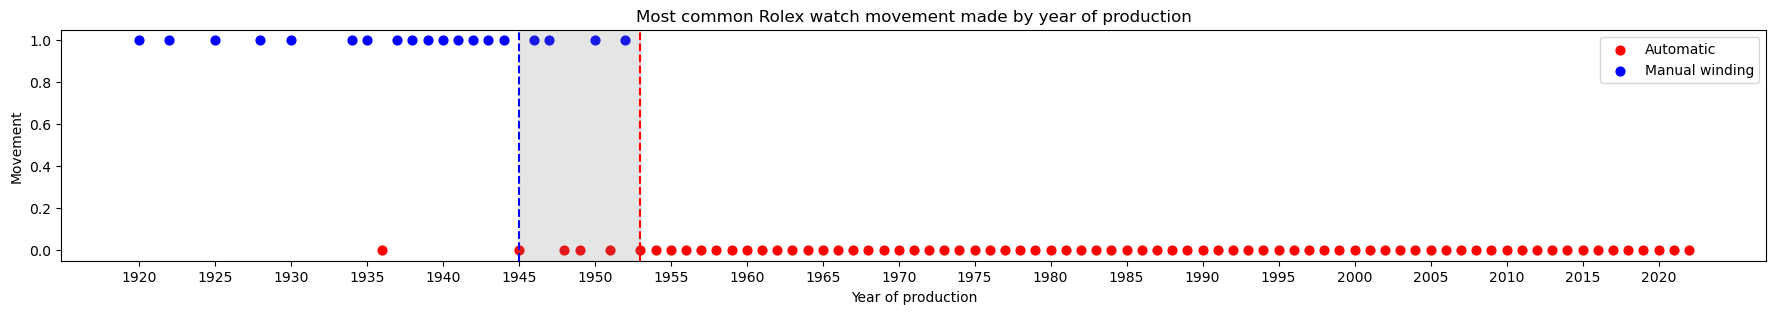

In [116]:
ax = plt.subplots(figsize=(22, 3))
scp1 = plt.scatter(res_mmdf_plot1['year of production'], res_mmdf_plot1['movement'], s=40, c='red', label='Automatic')
scp2 = plt.scatter(res_mmdf_plot2['year of production'], res_mmdf_plot2['movement'], s=40, c='blue', label='Manual winding')
plt.legend(handles=[scp1, scp2])
plt.title('Most common Rolex watch movement made by year of production')
plt.xlabel('Year of production')
plt.ylabel('Movement')

plt.axvline(x=1945, color='b', linestyle='--')
plt.axvline(x=1953, color='r', linestyle='--')
plt.axvspan(1945, 1953, alpha=0.2, color='grey')

plt.xticks(np.arange(1920, 2022, 5))

plt.show()

- 1910 - 1945: Manual winding movement 
- 1945 - 1953:  Confused ooga booga
- 1953 - now: Automatic movement

### Case material - group by

In [117]:
q2df.sort_values(by=['year of production'], ascending=False)

,model,movement,case material,case diameter,year of production
32018,Rolex Submariner Date,Automatic,Steel,41,2022.0
49965,Rolex Oyster Perpetual,Automatic,Steel,41,2022.0
49949,Rolex Sea-Dweller,Automatic,Gold/Steel,43,2022.0
24134,Rolex Datejust,Automatic,Gold/Steel,41,2022.0
24132,Rolex Day-Date,Automatic,Yellow gold,40,2022.0
...,...,...,...,...,...
31323,Rolex Precision,Manual winding,Steel,18,1922.0
17954,Rolex Prince,Manual winding,Silver,23,1920.0
44918,Rolex Prince,Manual winding,White gold,12,1920.0
30293,Rolex Prince,Manual winding,Yellow gold,10,1920.0


In [118]:
cmgb = q2df.groupby(
    ['year of production', 'case material']).count()

In [119]:
cmgb=cmgb.reset_index()
cmgb=cmgb.loc[:, ['year of production', 'case material', 'model']].rename(columns={'model': 'count'})

In [120]:
res_cm = cmgb.sort_values(
    by=['year of production', 'count'],
    ascending=[True, False]).drop_duplicates(
        subset=['year of production'],
        keep='first')

In [121]:
res_cm.to_csv('res_cm.csv', index=False)

In [122]:
material_list = tt['case material'].unique()
material_list

array(['Steel', 'White gold', 'Gold/Steel', 'Yellow gold', 'Rose gold',
       'Platinum', 'Silver', 'Red gold', 'Ceramic', 'Carbon', 'Titanium',
       'Aluminum'], dtype=object)

In [123]:
a_material_list = [m for m in material_list if res_cm.loc[res_cm['case material'] == m].shape[0] != 0]
a_material_list

['Steel', 'Gold/Steel', 'Yellow gold']

In [124]:
res_cm_plot = res_cm.copy()
for m in a_material_list:
    res_cm_plot['case material'] = res_cm_plot['case material'].replace(m, a_material_list.index(m))

res_cm_plot1 = res_cm_plot[res_cm_plot['case material'] == 0]
res_cm_plot2 = res_cm_plot[res_cm_plot['case material'] == 1]
res_cm_plot3 = res_cm_plot[res_cm_plot['case material'] == 2]


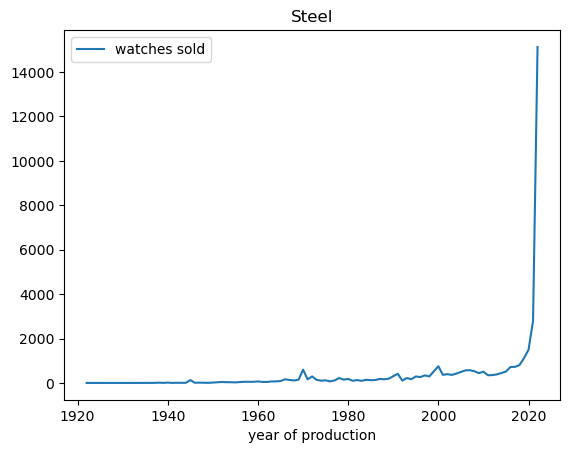

In [125]:
# Steel
# plot count
res_cm_plot1.plot(x = 'year of production', y = 'count', label='watches sold', title='Steel')
plt.legend()
plt.show()

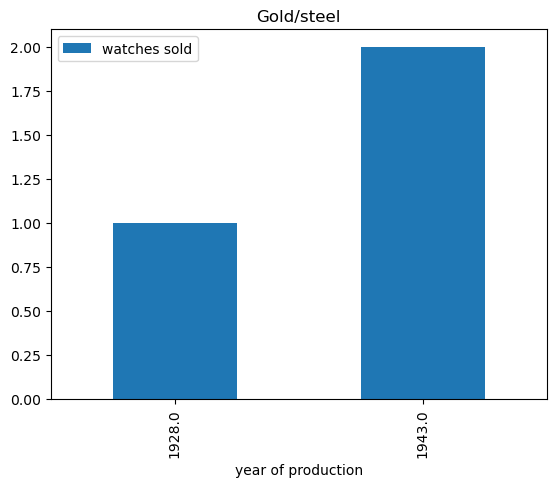

In [126]:
# Gold/steel
res_cm_plot2.plot(x = 'year of production', y = 'count', kind='bar', label='watches sold', title='Gold/steel')
plt.show()

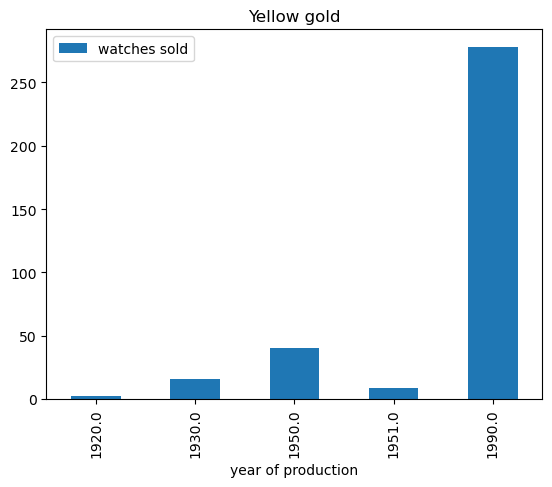

In [127]:
# Yellow gold
res_cm_plot3.plot(x = 'year of production', y = 'count', kind='bar', label='watches sold', title='Yellow gold')
plt.show()

In [128]:
a_material_list

['Steel', 'Gold/Steel', 'Yellow gold']

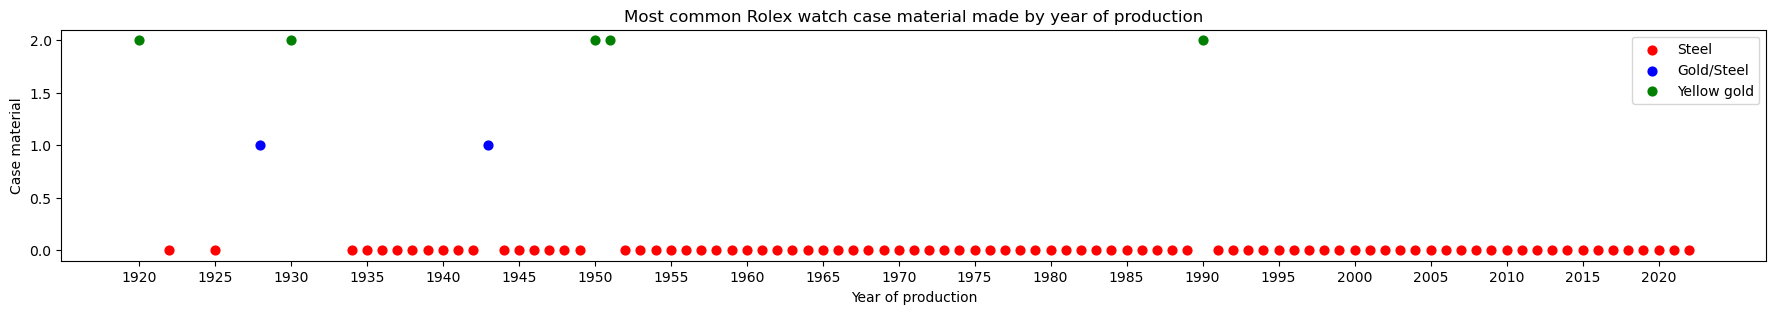

In [129]:
ax = plt.subplots(figsize=(22, 3))
scp1 = plt.scatter(res_cm_plot1['year of production'], res_cm_plot1['case material'], s=40, c='red', label='Steel')
scp2 = plt.scatter(res_cm_plot2['year of production'], res_cm_plot2['case material'], s=40, c='blue', label='Gold/Steel')
scp3 = plt.scatter(res_cm_plot3['year of production'], res_cm_plot3['case material'], s=40, c='green', label='Yellow gold')

plt.legend(handles=[scp1, scp2, scp3])
plt.title('Most common Rolex watch case material made by year of production')
plt.xlabel('Year of production')
plt.ylabel('Case material')

plt.xticks(np.arange(1920, 2022, 5))
plt.show()

## Question 3: 